In [136]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

entity_operation_id = 0

In [137]:
CODEBASE = "LdoD"
FEATURES_TO_EXTRACT = ["removeTweets", "approveParticipant", "associateCategory", "confirmRegistration", "createLinearVirtualEdition"]

# **Data representations**

We will now define the main structures that will be used to store data on the feature and clusters

In [138]:
class EntityMetrics():

    def __init__(self):
        # counts
        self.read_operations = 0                          # Total number of read operations
        self.write_operations = 0                         # Total number of write operations
        self.operations = 0                               # Total number of times that an entity is accessed
        self.pivot_operations = 0                  # Total number of other entities called between this entity operations
        # averages
        self.average_operations = 0.0    # Average number of times that an entity is accessed per cluster invocation
        self.average_pivot_operations = 0.0              # Average number of other entities accessed between entity operations


class Entity():
    
    def __init__(self, cluster_name, name):
        self.cluster_name = cluster_name
        self.name = name
        self.metrics = EntityMetrics()
        self.operation_ids = list()
        self.invocation_ids = list()

In [139]:
class Cluster():

    def __init__(self, name):
        self.name = name
        self.metrics = ClusterMetrics()
        self.entities = dict()
        self.invocation_ids = list()

    def get_or_create_entity(self, entity_name: str) -> Entity:
        if not self.entities.get(entity_name):
            self.entities[entity_name] = Entity(cluster_name=self.name, name=entity_name)
        
        return self.entities[entity_name]

class ClusterMetrics():
    
    def __init__(self):
        # counts
        self.lock_invocations = 0                       # Total number of invocations that have one or more write operations
        self.read_invocations = 0                       # Total number of invocations with only read operations, and no semantic lock
        self.invocations = 0                            # Total number of times that a cluster appears in the trace
        self.read_operations = 0                        # Total number of read operations in any given entity
        self.write_operations = 0                       # Total number of write operations in any given entity
        self.operations = 0                             # Total number of opperations in the entities of the cluster
        self.pivot_invocations = 0                      # Total number of external clusters accessed between all cluster invocations
        # averages
        self.average_invocation_operations = 0.0        # Average number of total entity operations per cluster invocations
        self.average_invocation_read_operations = 0.0   # Average number of read entity operations per cluster invocations
        self.average_invocation_write_operations = 0.0  # Average number of write entity operations per cluster invocations
        self.average_pivot_invocations = 0.0            # Average number of other clusters called between each cluster invocation
        # cluster probabilities
        self.lock_invocation_probability = 0.0
        self.read_invocation_probability = 0.0
        self.read_operation_probability = 0.0
        self.write_operation_probability = 0.0
        # feature-cluster probabilities
        self.invocation_probability = 0.0
        self.operation_probability = 0.0
        # factors
        self.pivot_invocations_factor = 0.0
        self.invocation_operations_factor = 0.0

In [140]:
class Feature():

    def __init__(self, name):
        self.name = name
        self.metrics = FeatureMetrics()
        self.clusters = dict()

    def get_or_create_cluster(self, cluster_name: str) -> Cluster:
        if not self.clusters.get(cluster_name):
            self.clusters[cluster_name] = Cluster(name=cluster_name)
        
        return self.clusters[cluster_name]

class FeatureMetrics():

    def __init__(self):
        self.complexity = 0.0
        # counts
        self.clusters = 0
        self.lock_invocations = 0
        self.read_invocations = 0
        self.invocations = 0
        self.read_operations = 0
        self.write_operations = 0
        self.operations = 0
        # averages
        self.average_invocation_operations = 0.0
        self.average_invocation_read_operations = 0.0
        self.average_invocation_write_operations = 0.0
        self.average_pivot_invocations = 0.0

# ➗ **Metrics calculation**

In [141]:
def calculate_invocation_metrics(feature: Feature, cluster: Cluster, trace_invocation): 
    global entity_operation_id
    has_semantick_lock = False

    feature.metrics.invocations += 1
    cluster.metrics.invocations += 1

    entity_operations = json.loads(trace_invocation["accessedEntities"])
    for entity_operation in entity_operations:
        entity_name = entity_operation[0]
        operation = entity_operation[1]

        entity = cluster.get_or_create_entity(entity_name)

        entity.invocation_ids.append(cluster.invocation_ids[len(cluster.invocation_ids) - 1])
        entity.operation_ids.append(entity_operation_id)
        entity_operation_id += 1

        feature.metrics.operations += 1
        cluster.metrics.operations += 1
        entity.metrics.operations += 1

        if operation == "R":
            feature.metrics.read_operations += 1
            cluster.metrics.read_operations += 1
            entity.metrics.read_operations += 1

        elif operation == "W":
            feature.metrics.write_operations += 1
            cluster.metrics.write_operations += 1
            entity.metrics.write_operations += 1
            has_semantick_lock = True

    if has_semantick_lock:
        feature.metrics.lock_invocations += 1
        cluster.metrics.lock_invocations += 1
    else:
        feature.metrics.read_invocations += 1
        cluster.metrics.read_invocations += 1


In [142]:
def calculate_cluster_averages(feature: Feature, cluster: Cluster):
    cluster.metrics.average_invocation_operations = float(cluster.metrics.operations / cluster.metrics.invocations)
    cluster.metrics.average_invocation_read_operations = float(cluster.metrics.read_operations / cluster.metrics.invocations)
    cluster.metrics.average_invocation_write_operations = float(cluster.metrics.write_operations / cluster.metrics.invocations)

    if cluster.metrics.invocations > 1:
        cluster.metrics.average_pivot_invocations = float(cluster.metrics.pivot_invocations / (cluster.metrics.invocations - 1))


def calculate_cluster_probabilities(feature: Feature, cluster: Cluster):
    cluster.metrics.lock_invocation_probability = float(cluster.metrics.lock_invocations / cluster.metrics.invocations)
    cluster.metrics.read_invocation_probability = float(cluster.metrics.read_invocations / cluster.metrics.invocations)
    cluster.metrics.read_operation_probability = float(cluster.metrics.read_operations / cluster.metrics.operations)
    cluster.metrics.write_operation_probability = float(cluster.metrics.write_operations / cluster.metrics.operations)
    cluster.metrics.invocation_probability = float(cluster.metrics.invocations / feature.metrics.invocations)
    cluster.metrics.operation_probability = float(cluster.metrics.operations / feature.metrics.operations)


def calculate_cluster_factors(feature: Feature, cluster: Cluster):
    cluster.metrics.pivot_invocations_factor = float(cluster.metrics.average_pivot_invocations / feature.metrics.average_pivot_invocations)
    cluster.metrics.invocation_operations_factor = float(cluster.metrics.average_invocation_operations / feature.metrics.average_invocation_operations)

In [143]:
def update_feature_averages(feature: Feature, cluster: Cluster):
    feature.metrics.average_invocation_operations += float(cluster.metrics.average_invocation_operations / feature.metrics.clusters)
    feature.metrics.average_invocation_read_operations += float(cluster.metrics.average_invocation_read_operations / feature.metrics.clusters)
    feature.metrics.average_invocation_write_operations += float(cluster.metrics.average_invocation_write_operations / feature.metrics.clusters)
    feature.metrics.average_pivot_invocations += float(cluster.metrics.average_pivot_invocations / feature.metrics.clusters)

In [144]:
def calculate_entity_averages(cluster: Cluster, entity: Entity):
    entity.metrics.average_operations = float(entity.metrics.operations / cluster.metrics.invocations)

    # entity.metrics.average_pivot_entity_operations

In [145]:
def calculate_final_metrics(feature: Feature):
    for _, cluster in feature.clusters.items():
        cluster.metrics.pivot_invocations = feature.metrics.invocations - cluster.metrics.invocations - cluster.invocation_ids[0] - (feature.metrics.invocations - cluster.invocation_ids[len(cluster.invocation_ids) - 1] - 1) # WE HAVE TO REMOVE THE NUMBER OF INVOCATIONS BEFORE THE FIRST ONE AND AFTER THE LAST ONE OF THIS CLUSTER

        calculate_cluster_averages(feature, cluster)
        calculate_cluster_probabilities(feature, cluster)

        update_feature_averages(feature, cluster)
        
        for _, entity in cluster.entities.items():
            calculate_entity_averages(cluster, entity)

    for _, cluster in feature.clusters.items():
        calculate_cluster_factors(feature, cluster)

# ✅ **Main script execution**

Next we define a method to **extract the data from each one of the trace files** into a list. 
This will contain all of the traces that will then be analyzed

In [146]:
def extract_traces():
  data = list()
  for feature_name in FEATURES_TO_EXTRACT:
    with open(f"{feature_name}.json") as json_file:
      data.append(json.load(json_file))
  return data

In [147]:
def extract_trace_metrics(trace_data) -> Feature:
  feature = Feature(name=trace_data["name"])
  feature.metrics.complexity = float(trace_data["complexity"])

  for trace_invocation in trace_data["functionalityRedesigns"][0]["redesign"]:
      invocation_id = int(trace_invocation["id"])
      if invocation_id == -1:
          continue

      if not feature.clusters.get(trace_invocation["cluster"]):
          feature.metrics.clusters += 1

      cluster = feature.get_or_create_cluster(trace_invocation["cluster"])
      cluster.invocation_ids.append(invocation_id)

      calculate_invocation_metrics(feature, cluster, trace_invocation)

  calculate_final_metrics(feature)
  return feature

In [148]:
trace_data = extract_traces()

features = list()
for trace in trace_data:
  feature = extract_trace_metrics(trace)
  features.append(feature)

# 📊 **Data visualization**

First we set the feature we want to visualize

In [149]:
feature = features[0]

## Plot helper methods

In [150]:
def plot_table(cellText, colLabels):
  fig, ax = plt.subplots()
  fig.set_figheight(1)

  # hide axes
  fig.patch.set_visible(False)
  ax.axis('off')
  ax.axis('tight')
  the_table = ax.table(cellText=cellText, colLabels=colLabels, loc='center')
  the_table.scale(2, 2)


def plot_multiple_bars(
    y_values_matrix, y_values_labels, y_legend, x_values, x_legend,
):
  # set width of bar 
  barWidth = 0.15
  fig = plt.subplots(figsize =(8, 4)) 

  colors = ['bisque', 'rosybrown', 'palegreen', 'turquoise', 'plum']
    
  # Set position of bar on X axis 
  br = [np.arange(len(y_values_matrix[0]))]
  for idx, _ in enumerate(y_values_matrix):
    br.append([x + barWidth for x in br[idx]]) 
    
  # Make the plot
  for idx, values in enumerate(y_values_matrix):
    plt.bar(br[idx], values, color = colors[idx], width = barWidth, 
            edgecolor = 'grey', label = y_values_labels[idx]) 

  # Adding Xticks  
  plt.xlabel(x_legend, fontweight ='bold') 
  plt.ylabel( y_legend, fontweight ='bold') 
  plt.xticks([r + barWidth for r in range(len(y_values_matrix[0]))], x_values) 
  leg = plt.legend()

  plt.show()


def plot_probability_stacked_bars(
    y_values_matrix, y_values_labels, y_legend, x_values, x_legend
):
  N = len(y_values_matrix[0])

  ind = np.arange(N)    
  width = 0.35  
    
  fig = plt.subplots(figsize = (8, 5)) 
  
  t = ()
  for idx, values in enumerate(y_values_matrix):
    if idx == 0:
      p = plt.bar(ind, values, width) 
    else:
      p = plt.bar(ind, values, width, bottom = y_values_matrix[idx-1]) 
    t += (p[0],)

  plt.ylabel(y_legend) 
  plt.title(x_legend) 
  plt.xticks(ind, x_values) 
  plt.yticks(np.arange(0, 1.3, 0.1)) 
  plt.legend(t, y_values_labels) 
    
  plt.show() 

## Feature metrics

Feature name:
 AdminController.removeTweets


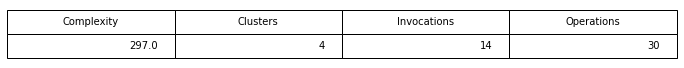

In [151]:
print("Feature name:\n",feature.name)
plot_table(
    cellText=[
              [
                feature.metrics.complexity,
                feature.metrics.clusters,
                feature.metrics.invocations,
                feature.metrics.operations,
              ]
            ],
    colLabels=[
                "Complexity",
                "Clusters",
                "Invocations",
                "Operations"
              ],
)

## Cluster metrics

### Counts

Cluster counts:


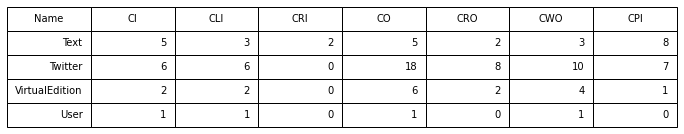

In [152]:
print("Cluster counts:")
plot_table(
    cellText=[
              [
                cluster.name,
                cluster.metrics.invocations,
                cluster.metrics.lock_invocations,
                cluster.metrics.read_invocations,
                cluster.metrics.operations,
                cluster.metrics.read_operations,
                cluster.metrics.write_operations, 
                cluster.metrics.pivot_invocations,
              ] for _, cluster in feature.clusters.items()
            ],
    colLabels=[
                "Name",
                "CI",
                "CLI",
                "CRI",
                "CO",
                "CRO",
                "CWO",
                "CPI",
              ],
)

### Averages

Cluster averages:


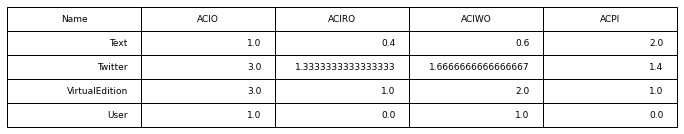

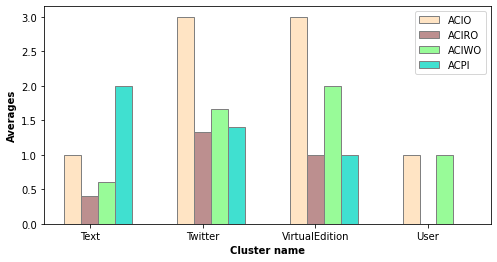

In [153]:
print("Cluster averages:")
# table
averages_matrix = [
                   [
                    cluster.name,
                    cluster.metrics.average_invocation_operations,
                    cluster.metrics.average_invocation_read_operations,
                    cluster.metrics.average_invocation_write_operations,
                    cluster.metrics.average_pivot_invocations,
                   ] for _, cluster in feature.clusters.items()
]

plot_table(
    cellText=averages_matrix,
    colLabels=["Name", "ACIO", "ACIRO", "ACIWO", "ACPI"],
)

# bar plot
averages_matrix = [
                   [cluster.metrics.average_invocation_operations for _, cluster in feature.clusters.items()],
                   [cluster.metrics.average_invocation_read_operations for _, cluster in feature.clusters.items()],
                   [cluster.metrics.average_invocation_write_operations for _, cluster in feature.clusters.items()],
                   [cluster.metrics.average_pivot_invocations for _, cluster in feature.clusters.items()],
]

plot_multiple_bars(
    y_values_matrix=averages_matrix,
    y_values_labels=["ACIO","ACIRO","ACIWO", "ACPI"],
    y_legend="Averages",
    x_values=[cluster.name for _, cluster in feature.clusters.items()],
    x_legend="Cluster name",
)

### Inside-cluster Probabilities

Inner cluster probabilities:


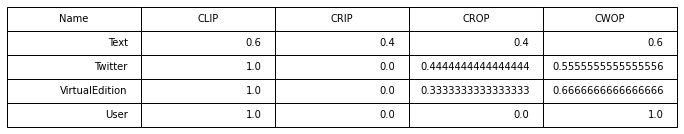

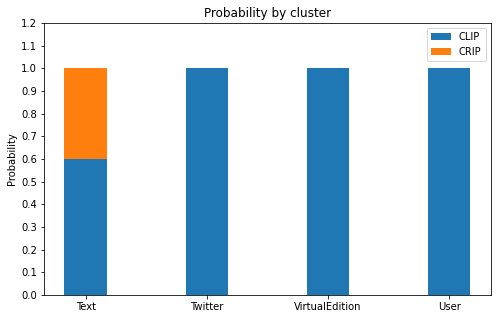

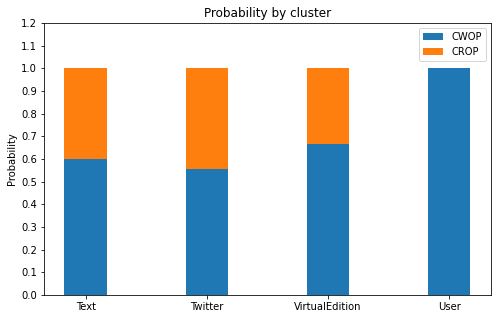

In [154]:
print("Inner cluster probabilities:")
plot_table(
    cellText=[
              [
                cluster.name,
                cluster.metrics.lock_invocation_probability,
                cluster.metrics.read_invocation_probability,
                cluster.metrics.read_operation_probability,
                cluster.metrics.write_operation_probability,
              ] for _, cluster in feature.clusters.items()
            ],
    colLabels=["Name", "CLIP", "CRIP", "CROP", "CWOP"],
)


plot_probability_stacked_bars(
    y_values_matrix=[
                   [cluster.metrics.lock_invocation_probability for _, cluster in feature.clusters.items()],
                   [cluster.metrics.read_invocation_probability for _, cluster in feature.clusters.items()],
    ],
    y_values_labels=("CLIP", "CRIP"),
    y_legend="Probability",
    x_values=(cluster.name for _, cluster in feature.clusters.items()),
    x_legend="Probability by cluster",
)  

plot_probability_stacked_bars(
    y_values_matrix=[
                   [cluster.metrics.write_operation_probability for _, cluster in feature.clusters.items()],
                   [cluster.metrics.read_operation_probability for _, cluster in feature.clusters.items()],
    ],
    y_values_labels=("CWOP", "CROP"),
    y_legend="Probability",
    x_values=(cluster.name for _, cluster in feature.clusters.items()),
    x_legend="Probability by cluster",
)

### Outside-cluster probabilities

Cluster/Feature probabilities:


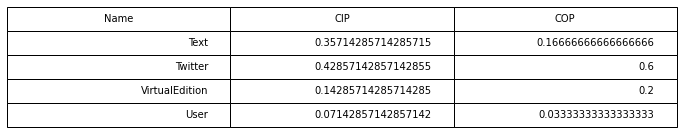

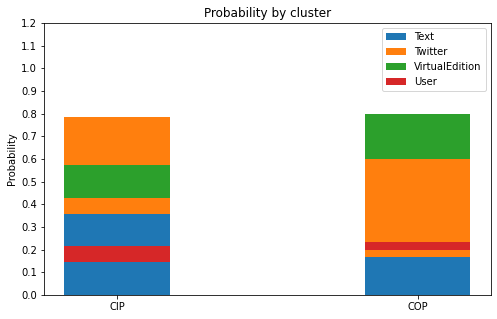

In [155]:
print("Cluster/Feature probabilities:")
plot_table(
    cellText=[
              [
                cluster.name,
                cluster.metrics.invocation_probability,
                cluster.metrics.operation_probability,
              ] for _, cluster in feature.clusters.items()
            ],
    colLabels=[
                "Name",
                "CIP",
                "COP",
              ],
)

plot_probability_stacked_bars(
    y_values_matrix=[
                   [
                    cluster.metrics.invocation_probability, 
                    cluster.metrics.operation_probability,
                   ] for _, cluster in feature.clusters.items()
    ],
    y_values_labels=(cluster.name for _, cluster in feature.clusters.items()),
    y_legend="Probability",
    x_values=("CIP", "COP"),
    x_legend="Probability by cluster",
)

### Factors

Cluster factors:


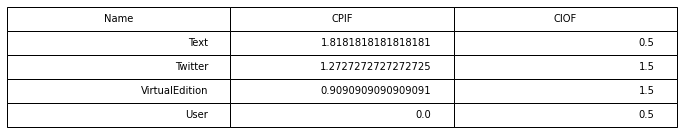

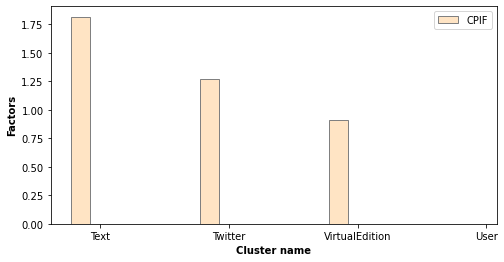

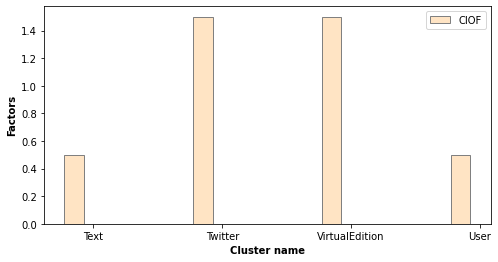

In [156]:
print("Cluster factors:")
plot_table(
    cellText=[
              [
                cluster.name,
                cluster.metrics.pivot_invocations_factor,
                cluster.metrics.invocation_operations_factor,
              ] for _, cluster in feature.clusters.items()
            ],
    colLabels=[
                "Name",
                "CPIF",
                "CIOF",
              ],
)

plot_multiple_bars(
    y_values_matrix=[
                   [cluster.metrics.pivot_invocations_factor for _, cluster in feature.clusters.items()],
    ],
    y_values_labels=["CPIF"],
    y_legend="Factors",
    x_values=[cluster.name for _, cluster in feature.clusters.items()],
    x_legend="Cluster name",
)

plot_multiple_bars(
    y_values_matrix=[
                   [cluster.metrics.invocation_operations_factor for _, cluster in feature.clusters.items()],
    ],
    y_values_labels=["CIOF"],
    y_legend="Factors",
    x_values=[cluster.name for _, cluster in feature.clusters.items()],
    x_legend="Cluster name",
)

# Data extraction

The training vector we are using has the following format. Features are identified in the first column and the clusters in the second. Then we follow the data with the metrics we are using to train the model.


In this part we want to generate a **.csv file** that can then be loaded into our Tensorflow engine.

| Feature | Cluster | CLIP  | CRIP | CROP  | CWOP | CIP | COP | CPIF | CIOF |
|---|---|---|---|---|---|---|---|---|---|		
| AdminController.removeTweets | Text | 0.4 | 0.6 | 0.33 | 0.66 | 0.2 | 0.4 | 1.4 | 0.8 |			
| AdminController.removeTweets | VirtualEdition  | 0.4 | 0.6 | 0.33 | 0.66 | 0.3 | 0.4 | 1.4 | 0.8 |			
| AdminController.removeTweets |  Twitter | 0.4 | 0.6 | 0.33 | 0.66 | 0.4 | 0.3 | 0.7 | 0.2 |			

In [157]:
import csv

with open('trace_analysis.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Feature", "Cluster", "CLIP", "CRIP", "CROP", "CWOP", "CIP", "COP", "CPIF", "CIOF"])
    
    for feature in features:
      for _, cluster in feature.clusters.items():
        writer.writerow(
            [
             feature.name,
             cluster.name,
             cluster.metrics.lock_invocation_probability,
             cluster.metrics.read_invocation_probability,
             cluster.metrics.read_operation_probability,
             cluster.metrics.write_operation_probability,
             cluster.metrics.invocation_probability,
             cluster.metrics.operation_probability,
             cluster.metrics.pivot_invocations_factor,
             cluster.metrics.invocation_operations_factor,
            ]
        )
    